In [1]:
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from src.lexrank import degree_centrality_scores
import ot
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from gensim.parsing.preprocessing import preprocess_documents

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

In [2]:
DATASET = DATASETS[1]
EMBEDDINGS_DIR = os.path.join(DATA_DIR, 'BERT')

## Experiments

In [3]:
def load_and_extract_topic(data_dir, topic_id):
    topic = load_data(data_dir, topic_id, encoded=True)
    return extract(topic)

In [4]:
def execute_experiment(data_dir, tac, experiment):
    data   = [ load_and_extract_topic(data_dir, topic_id) for topic_id in tac ]
    scores = [ experiment(d) for d in data ]

    return np.array(scores)

In [6]:
def experiment_average_pairwise_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: average_pairwise_distance(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_semantic_volume(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    metric = lambda i: semantic_volume(np.array(summary_pts[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_semantic_spread(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: semantic_spread(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_word_mover_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_hist = []
    # document_hist = np.empty(document_embs.shape[0])
    # document_hist.fill(1 / document_embs.shape[0])
    metric = lambda i: word_mover_distance(document_embs, np.array(summary_embs[i[0]:i[1]]), document_hist)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_lex_rank(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    metric = lambda i: lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

## Scores

In [7]:
scores = [
#     {
#         'label': 'Average pairwise distance',
#         'experiment': experiment_average_pairwise_distance 
#     },
#     {
#         'label': 'Semantic volume',
#         'experiment': experiment_semantic_volume 
#     },
#     {
#         'label': 'Semantic spread',
#         'experiment': experiment_semantic_spread 
#     },
    {
        'label': 'Word Mover distance',
        'experiment': experiment_word_mover_distance 
    }
]

ptr = ''
print(f'=== Experiments {DATASET} ===\n')
for i,s in enumerate(scores):
    print('Executing "{}"'.format(s['label']))
    start = time.time()
    scores[i]['values'] = execute_experiment(os.path.join(EMBEDDINGS_DIR, DATASET), TOPICS[DATASET], s['experiment'])
    print('*** Elapsed: {:}\n'.format(format_time(time.time() - start)))
    ptr += '{:30} {:.4}\n'.format(s['label'], np.mean(scores[i]['values']))
    del s['experiment']
print('\n=== Results ===\n')
print(ptr)

=== Experiments TAC2009 ===

Executing "Word Mover distance"


/Users/korunosk/opt/anaconda3/envs/dlab/lib/python3.7/site-packages/ot/lp/__init__.py:230: UserWarning:

Problem infeasible. Check that a and b are in the simplex



*** Elapsed: 0:00:11


=== Results ===

Word Mover distance            0.05908



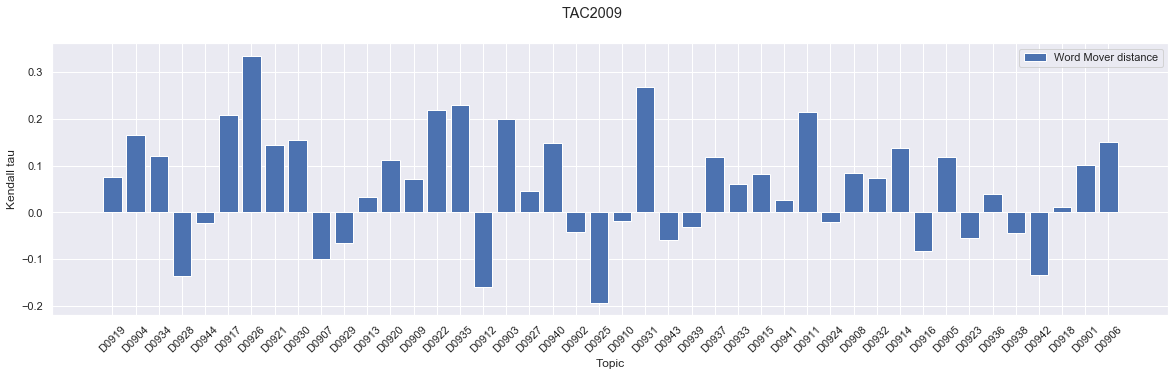

In [8]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(DATASET)
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores)
plt.show()

## Experimental

### Make data

In [8]:
data = []

for dataset_id in DATASETS:
    print(dataset_id)
    for topic_id in TOPICS[dataset_id]:
        document_embs, summary_embs, indices, pyr_scores, summary_ids = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, dataset_id), topic_id)
        document_embs = np.array(document_embs)

        document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))

        for p,i in enumerate(indices):
            data.append({
                'dataset_id': dataset_id,
                'topic_id': topic_id,
                'summ_id': summary_ids[p],
                'average_pairwise_distance': average_pairwise_distance(np.array(summary_embs[i[0]:i[1]])),
                'semantic_volume': semantic_volume(np.array(summary_pts[i[0]:i[1]])),
                'semantic_spread': semantic_spread(np.array(summary_embs[i[0]:i[1]])),
                'lex_rank': lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores),
                'pyr_score': pyr_scores[p]
            })

df = pd.DataFrame(data)

TAC2008
TAC2009


In [32]:
df.groupby(['dataset_id', 'topic_id']).corr(method='kendall')[['pyr_score']]

pyr_score
dataset_id topic_id                                     
TAC2008    D0801    average_pairwise_distance   0.158436
                    semantic_volume             0.036986
                    semantic_spread             0.217357
                    lex_rank                    0.216013
                    pyr_score                   1.000000
...                                                  ...
TAC2009    D0944    average_pairwise_distance   0.153485
                    semantic_volume             0.247758
                    semantic_spread             0.182287
                    lex_rank                    0.177325
                    pyr_score                   1.000000

[460 rows x 1 columns]

In [10]:
df_tmp = df[df.dataset_id == DATASET]

In [11]:
def print_sentences(summary):
    for i, sentence in enumerate(summary):
        print('{:3}. {}'.format(i+1, sentence))

In [12]:
tac = load_data(DATA_DIR, DATASET, encoded=False)

In [13]:
# Topic ID with high correlation coefficient
TOPIC_ID = 'D0934'
documents, summaries, indices, _, summary_ids = extract(tac[TOPIC_ID])

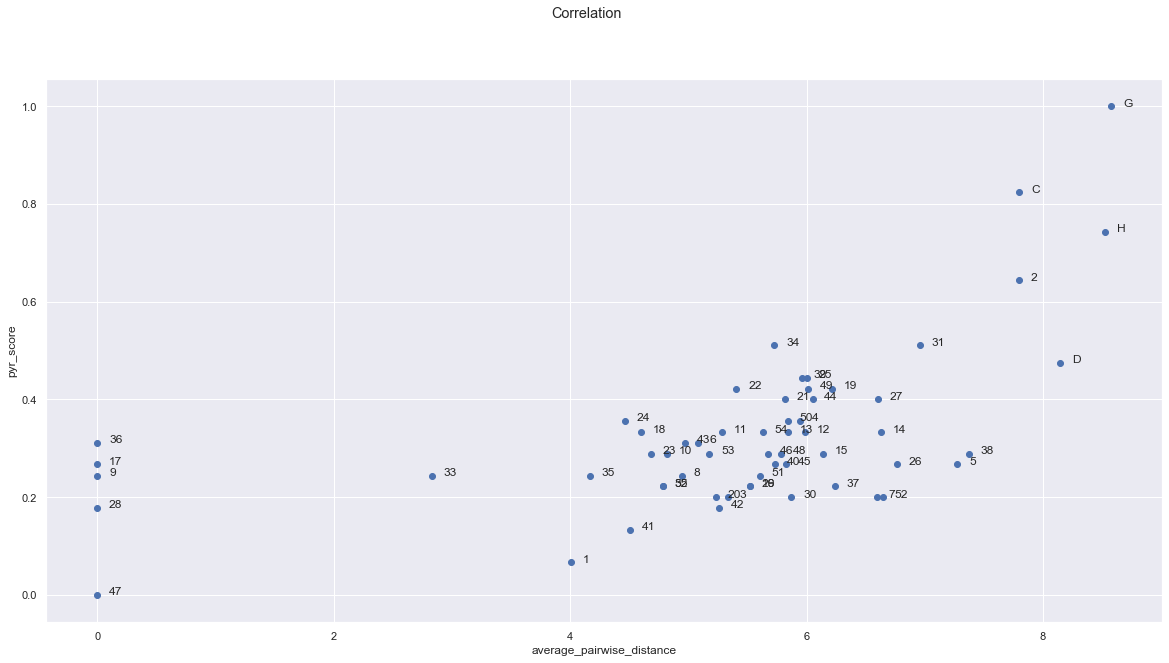

In [14]:
# Scatter plot of metric vs Pyramid score
fig = plt.figure(figsize=(20,10))
fig.suptitle('Correlation')
ax = fig.add_subplot(1,1,1)
plot_corr(ax, df_tmp, TOPIC_ID, 'average_pairwise_distance')
plt.show()

In [15]:
# Print sentences in summary where the metric and the Pyramid score agree
SUMMARY_ID = int(np.where(np.array(summary_ids) == 'G')[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. On October 23, Tunisian doctors were allowed to see Yasser Arafat, who was hospitalized two days later.
  2. Rumors on his ailment and condition began spreading.
  3. On October 28, his move to a Paris hospital was approved.
  4. He entered the intensive care unit on November 3.
  5. As contradicting reports of his condition continued, rumors on his funeral and burial began to surface.
  6. Arafat supposedly wanted a Jerusalem grave.
  7. This is opposed by Israel, which wants burial in the Gaza Strip.
  8. Palestinian sources mentioned Ramallah.
  9. Egypt offered to host the funeral.
 10. Agreement among Palestinian and Israeli officials was reached on November 9.


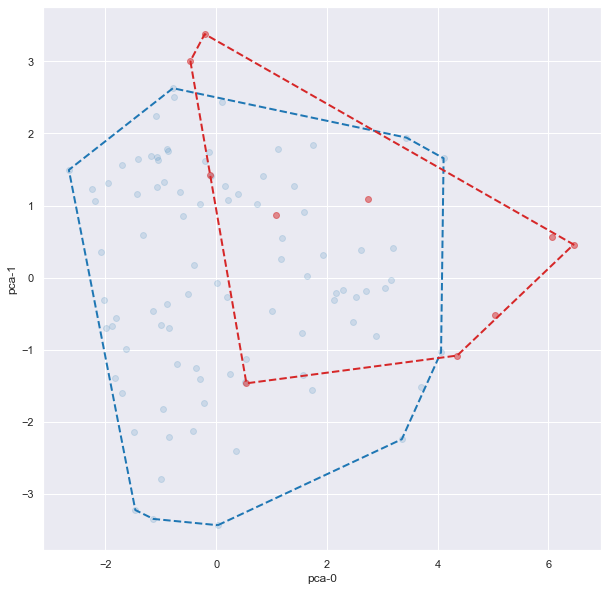

In [16]:
# Plot projection of such summary
document_embs, summary_embs, indices, _, _ = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, DATASET), TOPIC_ID)
document_embs = np.array(document_embs)

document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
plot_hull('pca', ax1, '', document_pts, summary_pts[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])
plt.show()

### Why do certain summaries have 0 Pyramid score?

In [18]:
# Ratio between the number of summaries with 0 Pyramid score and the ones with > 0 Pyramid score
df_tmp[df_tmp.pyr_score == 0].groupby('topic_id').apply(len) / df_tmp[df_tmp.pyr_score > 0].groupby('topic_id').apply(len) * 100

topic_id
D0901     5.357143
D0902    11.538462
D0903    18.000000
D0904     9.259259
D0905    28.260870
D0906     1.724138
D0907    18.000000
D0908          NaN
D0909     1.724138
D0910     3.508772
D0911          NaN
D0912    18.000000
D0913     3.508772
D0914     1.724138
D0915     3.571429
D0916     3.508772
D0917     5.454545
D0918    13.461538
D0919          NaN
D0920    20.408163
D0921          NaN
D0922     5.357143
D0923    11.320755
D0924     5.357143
D0925     3.508772
D0926     5.357143
D0927     9.433962
D0928     7.272727
D0929     3.571429
D0930    11.320755
D0931     9.259259
D0932     1.724138
D0933    20.408163
D0934     1.724138
D0935     5.357143
D0936     3.508772
D0937     3.508772
D0938     5.357143
D0939     1.724138
D0940     5.357143
D0941     1.754386
D0942    22.916667
D0943     3.508772
D0944    13.461538
dtype: float64

In [19]:
# Summaries with 0 Pyramid score
df_tmp[df_tmp.pyr_score == 0]

,dataset_id,topic_id,summ_id,average_pairwise_distance,semantic_volume,semantic_spread,lex_rank,pyr_score
3038,TAC2009,D0904,5,8.359042,21.268761,1.539979e+11,11.793768,0.0
3042,TAC2009,D0904,9,0.000000,0.000000,0.000000e+00,1.965628,0.0
3050,TAC2009,D0904,17,4.126753,0.000000,8.932643e+03,3.931256,0.0
3061,TAC2009,D0904,28,4.450281,0.247354,1.777571e+05,5.896884,0.0
3072,TAC2009,D0904,39,8.895357,11.292881,4.440664e+14,15.176381,0.0
...,...,...,...,...,...,...,...,...
5434,TAC2009,D0918,47,0.000000,0.000000,0.000000e+00,1.538014,0.0
5455,TAC2009,D0901,9,0.000000,0.000000,0.000000e+00,1.959899,0.0
5471,TAC2009,D0901,25,6.744337,1.654280,3.420722e+07,7.898082,0.0
5474,TAC2009,D0901,28,0.000000,0.000000,0.000000e+00,1.959899,0.0


In [20]:
# Print sentences in summaries with 0 Pyramid score, per topic
for topic_id, df_group in df_tmp[df_tmp.pyr_score == 0].groupby('topic_id'):
    print(f'=== {DATASET} ===\n')
    for _, row in df_group.iterrows():
        document_embs, summary_embs, indices, _, _ = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, DATASET), topic_id)
        summary_id = int(np.where(np.array(summary_ids) == row['summ_id'])[0])
        print(f'   Summary ID: {summary_id}\n')
        print_sentences(summaries[indices[summary_id][0]:indices[summary_id][1]])
        print()

=== TAC2009 ===

   Summary ID: 8

  1. Palestinian leader Yasser Arafat would

   Summary ID: 24

  1. Herewith a summary of events related to Palestinian leader Yasser Arafat's health situation.
  2. Senior Palestinian official Yasser Abed Rabbo denied on Tuesday reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  3. An agreement on funeral arrangements to be made in the aftermath of Yasser Arafat's death was reached Tuesday by Israeli and Palestinian officials, a senior Palestinian official said on condition of anonymity.
  4. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat, a senior Israeli official told AFP Tuesday.

   Summary ID: 27

  1. Nov 7: French Foreign Minister Michel Barnier say Arafat is alive but in serious condition.

=== TAC2009 ===

   Summary ID: 0

  1. An agreement on funeral arrangements to be made in the aftermath of Yasser Arafat's death was reached Tuesday by Isr

   Summary ID: 4

  1. Herewith a summary of events related to Palestinian leader Yasser Arafat's health situation.
  2. Oct 25: Israel allows Arafat to leave his Ramallah headquarters, to be treated at a local hospital.
  3. Once dead, being buried in Jerusalem's Al-Aqsa mosque compound.
  4. Nov 7: French Foreign Minister Michel Barnier say Arafat is alive but in serious condition.
  5. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat.
  6. The extraordinary turn of events is an indication of the confusing court politics surrounding Arafat.

   Summary ID: 8

  1. Palestinian leader Yasser Arafat was not dead at 3:30 pm, a French official said.

   Summary ID: 16

  1. Egypt is reportedly to have offered to hold a funeral service for Arafat, partly to spare Arab leaders from Israeli security measures they have to go through if they go to the Palestinian territories to pay their last respect to the Palestinian leader.
  2. 

   Summary ID: 38

  1. Israel is preparing for a possible escalation of violence after the death of Arafat the Israeli defense minister
  2. Top Palestinian officials abruptly postponed a trip to Paris to ascertain the real condition of ailing leader Yasser Arafat after critical comments by his wife.
  3. Herewith a summary of events related to Palestinian leader Yasser Arafat's health situation.
  4. Senior Palestinian official Yasser Abed Rabbo denied reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  5. Palestinian leader Yasser Arafat would be buried at his headquarters in the West Bank town of Ramallah.
  6. Ahmed Sobeih told Xinhua late Tuesday.

=== TAC2009 ===

   Summary ID: 4

  1. Palestinian leader Yasser Arafat was not dead at 3:30 pm.
  2. Senior Palestinian official Yasser Abed Rabbo denied on Tuesday reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  3. An agreement on funeral arrangements to be made

   Summary ID: 8

  1. - Palestinian prime minister Ahmed Qorei says Arafat is in critical condition.

   Summary ID: 12

  1. Nov 9: Arafat's spokeswoman Leila Shahid says the four leaders -- Abbas, prime minister Ahmed Qorei, foreign minister Nabil Shaath and parliament speaker Rawhi Fattuh Qorei -- will see the ailing Arafat.
  2. - Palestinian prime minister Ahmed Qorei says Arafat is in critical condition.
  3. An official at the army medical service said that Arafat "is not dead."

   Summary ID: 21

  1. Nov 7: French Foreign Minister Michel Barnier say Arafat is alive but in serious condition.
  2. Oct 30: Palestinian officials deny reports that Arafat is suffering from leukemia or that he has lost his faculties.
  3. As Arafat had struggled for life, there has been wild guess as to where he might be buried and where to hold the funeral service.

   Summary ID: 24

  1. Palestinian foreign minister  Nabil Shaath  denied a claim by a fellow cabinet minister Tuesday that  Arafat 

   Summary ID: 38

  1. Ahmed Sobeih told Xinhua late Tuesday.
  2. Palestinian leader Yasser Arafat was not dead at 3: 30 pm.
  3. Israeli and Palestinian officials will begin talks overnight
  4. Egypt is reportedly to have offered to hold a funeral service for Arafat, partly to spare Arab leaders from Israeli security measures they have to go through if they go to the Palestinian territories to pay their last respect to the Palestinian leader.
  5. As Arafat had struggled for life, there has been wild guess as to where he might be buried and where to hold the funeral service.
  6. Earlier in the day, the Arabic-language news network said that Arafat had died at a French military hospital.
  7. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat.

   Summary ID: 46

  1. The 13 main Palestinian factions held an emergency meeting Tuesday to discuss arrangements to follow an official announcement that Palestinian leader Yasser 

   Summary ID: 27

  1. Arafat 's condition was described as unchanged by a spokesman of the French  military hospital in  Paris  where  Arafat  is variously said to be in an irreversible coma, a reversible one or no coma at all.

   Summary ID: 30

  1. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat, a senior Israeli official told AFP Tuesday.
  2. Senior Palestinian official Yasser Abed Rabbo denied on Tuesday reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  3. Senior Palestinian and Israeli officials have reached an agreement in principle on the arrangements to be made after the death of president Arafat, the
  4. Senior Palestinian official Yasser Abed Rabbo denied on Tuesday reports saying that Palestinian leader Yasser Arafat has died in a French hospital.

   Summary ID: 38

  1. His situation is very difficult and critical, he told reporters.Palestinian leader Yasser Arafat was 

   Summary ID: 45

  1. Yasser Arafat is in a "very difficult and serious"  situation, the Palestinian foreign minister said Tuesday after he and other officials met their critically ill leader's doctors.
  2. An agreement on funeral arrangements to be made in the aftermath of Yasser Arafat's death was reached Tuesday by Israeli and Palestinian officials.
  3. Abed Rabbo told reporters in the West Bank city of Ramallah that the reports saying that Arafat who suffers from a deep coma earlier Tuesday had died "are totally untrue,"adding that"  Arafat is still alive ".
  4. Nov 2: Doctors issue a medical bulletin saying Arafat's illness is not leukemia but fail to disclose the exact nature of his illness.
  5. One of Arafat's doctors says he is suffering from a blood disease related to a viral infection, cancer or blood poisoning and must be hospitalized overseas.

=== TAC2009 ===

   Summary ID: 21

  1. Tuesday witnessed a flurry of conflicting reports on Arafat's fate.
  2. Israeli, Pa

   Summary ID: 16

  1. Nov 5 : Aqsa's spokeswoman in Paris says Arafat is 'between life and death ' and in a reversible coma.

   Summary ID: 27

  1. Tuesday witnessed a flurry of conflicting reports on Arafat's fate.

   Summary ID: 45

  1. Related to Palestinian leader Yasser Arafat's health situation.
  2. Senior Palestinian official Yasser Abed Rabbo denied on Tuesday reports saying that Palestinian leader Yasser Arafat has died in a French hospital.
  3. Israeli and Palestinian officials will begin talks overnight to discuss funeral arrangements for Yasser Arafat, a senior Israeli official.

   Summary ID: 46

  1. Senior Palestinian official Yasser Abed Rabbo denied reports saying that Palestinian leader Yasser Arafat has died in a French hospital.

=== TAC2009 ===

   Summary ID: 50

  1. - Palestinian television airs images of Arafat in pyjamas.
  2. The 13 main Palestinian factions held an emergency meeting Tuesday to discuss arrangements to follow an official announcement 

   Summary ID: 16

  1. - One of Arafat's doctors says

   Summary ID: 27

  1. Tuesday witnessed a flurry of conflicting reports on Arafat's fate.

=== TAC2009 ===

   Summary ID: 0

  1. An agreement on funeral arrangements to be made in the aftermath of Yasser Arafat's death was reached Tuesday by Israeli and Palestinian officials, a senior Palestinian official said on condition of anonymity.
  2. "Senior Palestinian and Israeli officials have reached an agreement in principle on the arrangements to be made after the death of president Arafat," the official told AFP.
  3. He refused to give further details about the agreement, and in particular whether Israel had given the go-ahead for the Palestinian leader to eventually be buried in his battered Muqataa compound in the West Bank town of Ramallah.

   Summary ID: 16

  1. Palestinian factions emergency meeting discuss arrangements to follow Palestinian leader Yasser Arafat has died.

   Summary ID: 46

  1. An agreement on funeral 

   Summary ID: 35

  1. Arafat to be buried in Ramallah: sources.

   Summary ID: 36

  1. Arafat not dead at 3:30 pm (1430 GMT): French officials (ADDS other denials, death claim from Ramallah).
  2. Abed Rabbo told reporters in the West Bank city of Ramallah that the reports saying that Arafat
  3. His situation is very difficult and critical, he told reporters.Palestinian leader Yasser Arafat was not dead at 3:30 pm (1430 GMT), a French official said.The statement made public by General Christian Estripeau is still valid at 3:30 pm, he said.Estripeau, the medical services official spokesman.Two senior Palestinian officals Nasser el-Qidwa and Leila Shahid also denied that Arafat was dead.He did not say what the diagnosis was, or whether the delegation had actually seen Arafat face to face.
  4. Nov 2: Doctors issue a medical bulletin saying Arafat's illness is not leukemia but fail to disclose the exact nature of Arafat's illness.
  5. " We are in the process of discussing the steps 

### Why do scores not agree?

In [21]:
# Print topics with 0 Pyramid score, ordered by number of summaries
df_tmp[df_tmp.pyr_score == 0].groupby('topic_id').apply(len).sort_values().head()

topic_id
D0941    1
D0939    1
D0932    1
D0906    1
D0934    1
dtype: int64

In [22]:
# Extract the un-encoded data of one such topic
TOPIC_ID = 'D0941'
documents, summaries, indices, _, summary_ids = extract(tac[TOPIC_ID])

In [23]:
# Select the data for the topic from the dataframe
df_tmp = df[df.topic_id == TOPIC_ID].sort_values(by='pyr_score')

In [24]:
# Print sentences in worst summary
SUMMARY_ID = int(np.where(np.array(summary_ids) == df_tmp.iloc[0].summ_id)[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. "This will be like a Jules Verne adventure," she said.


In [25]:
# Print sentences in best summary
SUMMARY_ID = int(np.where(np.array(summary_ids) == df_tmp.iloc[-1].summ_id)[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. The Huygens space probe, built and managed by the European Space Agency, was carried by NASA's Cassini spacecraft on a 7-year journey to Saturn.
  2. It separated successfully from Cassini on Christmas Eve and began a 2.5-million-mile 20-day descent to Saturn's largest moon Titan, the only moon in the solar system that has atmosphere.
  3. During its descent it will sample Titan's atmosphere.
  4. Everything must work perfectly because there is no way to adjust Huygens' course.
  5. Progress was being carefully followed by NASA and the 16 European nations involved in the project.


### Regression analysis

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,3:-1], df.iloc[:,-1], stratify=df.iloc[:,0])

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

estimator = Ridge()

parameters = { 'alpha': np.linspace(0, 1, 100) }

cv = GridSearchCV(estimator, parameters, scoring='neg_mean_squared_error', cv=10)

cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

{'alpha': 1.0}
-0.03490338877929981


In [28]:
best_estimator = cv.best_estimator_
best_estimator.score(X_test, y_test)

-0.08098406327017837

### Combination of Relevance and Redundancy metrics

In [22]:
for alpha in np.linspace(0,1,10):

    def experiment_comb(document_embs, summary_embs, indices, pyr_scores):
        metric_1 = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
        scores_1 = calculate_scores(indices, metric_1)

        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
        metric_2 = lambda i: lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores)
        scores_2 = calculate_scores(indices, metric_2)

        scores = (1-alpha) * scores_1 + alpha * scores_2

        return kendalltau(pyr_scores, scores)[0]

    print(np.mean(execute_experiment(tac_encoded, experiment_comb)))

0.1608747108305918
0.1608979399420694
0.1608979399420694
0.1608979399420694
0.16092551325990417
0.16092551325990417
0.16092551325990417
0.16092551325990417
0.16095283924824696
0.19811498302816635


### Exporting best summaries for all datasets

In [25]:
for dataset in DATASETS:
    tac = load_data(DATA_DIR, dataset, encoded=True)
    print(f'{dataset}')
    
    for topic_id, topic in tac.items():
        document_embs, summary_embs, indices, pyr_scores, summary_ids = extract(topic)

        m = np.argsort(-pyr_scores)

        embeddings = {
            'tag': f'{DATASET}:{topic_id}:System Summaries:BERT',
            'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
            'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
        }

        make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

TAC2008
TAC2009


# Plotting BERT

In [70]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid scores
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

## System Summaries

### TensorBoard

In [12]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:System Summaries:BERT',
    'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
    'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

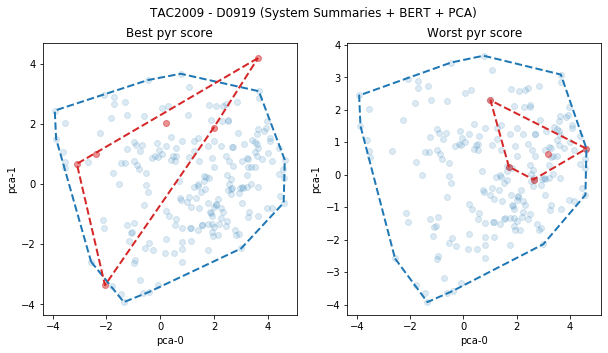

In [13]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + PCA)')
ax1 = fig.add_subplot(1,2,1)
plot('pca', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('pca', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 473 samples in 0.015s...
[t-SNE] Computed neighbors for 473 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 473 / 473
[t-SNE] Mean sigma: 2.878953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.332146
[t-SNE] KL divergence after 2400 iterations: 0.672893


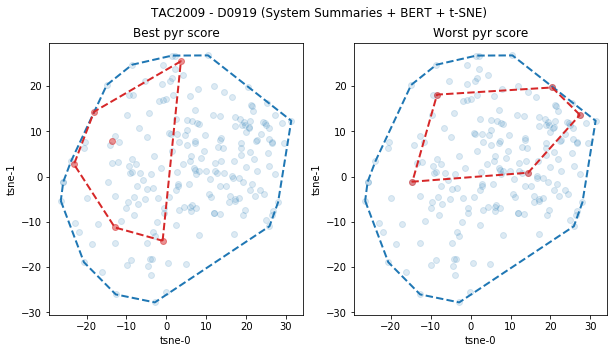

In [14]:
document_pts, summary_pts = project_tsne(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + t-SNE)')
ax1 = fig.add_subplot(1,2,1)
plot('tsne', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('tsne', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

## Extractive Summarization by Maximizing Semantic Volume

In [15]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [16]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:BERT',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

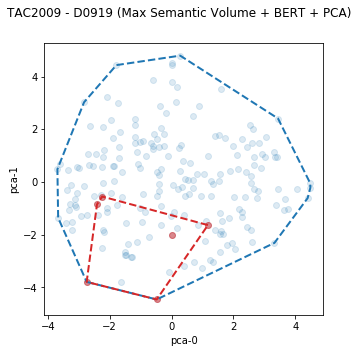

In [17]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.004s...
[t-SNE] Computed neighbors for 208 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 2.745973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.173157
[t-SNE] KL divergence after 1050 iterations: 0.777134


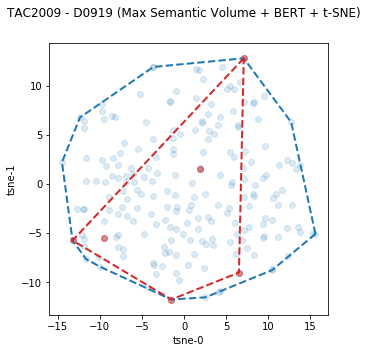

In [18]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Plotting SVD

In [19]:
### Load
tac = load_data(DATASET, encoded=False)

### Extract
topic = tac[TOPIC]
documents, summaries, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd

### Count bigrams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), binary=True)
X = vectorizer.fit_transform(documents)

# If bigram b is present in s_i,
# we let s_i,b be the number of documents
# in the corpus that contain bigram b, and
# zero otherwise.
nd = X.sum(axis=0)
S = X.multiply(nd)

### Decompose
U, Sigma, VT = randomized_svd(S, n_components=100, n_iter=5, random_state=42)

# We then perform singular value decomposition (SVD)
# on S. We use U_K as the sentence representations.

In [21]:
document_embs = U

## Extractive Summarization by Maximizing Semantic Volume

In [22]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [23]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:SVD',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

###  PCA

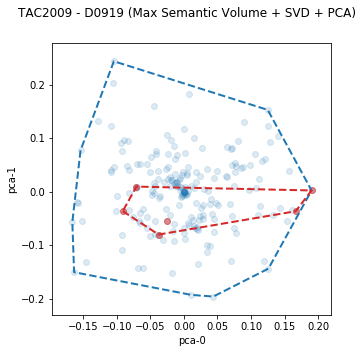

In [24]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.001s...
[t-SNE] Computed neighbors for 208 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.240379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.293152
[t-SNE] KL divergence after 1400 iterations: 1.076915


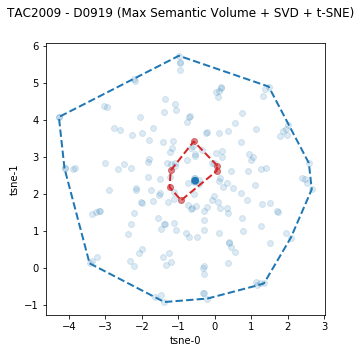

In [25]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Interactive plot BERT

In [26]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

### PCA

In [27]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(summary_pts[indices[m[i],0]:indices[m[i],1]], f'sum-{i+1}') for i in range(len(m))], ignore_index=True)

In [28]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           title=DATASET + ' - ' + TOPIC,
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…